# Tutorial Julia for Data Science

## 9 Reti Neurali

Questa parte riguarda la costruzione e allenamento di reti neurali.  
Come esempio introduttivo creeremo una rete che riesca a predirre il numero disegnato in un immagine in bianco e nero.  
Iniziamo inizializzando ambiente:

In [2]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.resolve()

mkpath("downloads")
mkpath("out")

 Activating environment at `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\tutorial\Project.toml`
No Changes to `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\tutorial\Project.toml`
No Changes to `C:\Users\i am\Documents\GitHub\stage-Machine-learning\notebook\tutorial\Manifest.toml`


"out"

In [3]:
using Flux, Flux.Data.MNIST
using Flux: onehotbatch, argmax, crossentropy, throttle
using Base.Iterators: repeated
using Images

Per calcolare velocemente operazioni tra matrici le svolgeremo sulla GPU.  
Le GPU sono in genere molto ottimizzatre nel calcolo di matrici di Float32, quindi converteremo i nostri dati in matrici di Float32.

Iniziamo prendendo il dataset di immagini:

typeof(imgs[100]) = Array{Gray{Normed{UInt8,8}},2}


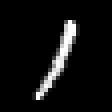

In [4]:
imgs = MNIST.images()
@show typeof(imgs[100])
colorview(Gray, imgs[100])

Ogni elemento di imgs è un immagine, convertiamole in matrici di Float32.

In [5]:
myFloat32(X) = Float32.(X) #definiamo funzione per convertire campi matrice in float32 al volo
fpt_imgs = myFloat32.(imgs)#eseguiamola su ogni elemento del dataset di immagini
#otteniamo dataset di matrici di float32
@show typeof(fpt_imgs[3])#tipo di un elemento dopo conversione

typeof(fpt_imgs[3]) = Array{Float32,2}


Array{Float32,2}

Adesso abbiamo un array di matrici di Float32, non ci basta, convertiamo ogni matrice(ogni immagine) in un array.  

In [7]:
@show typeof(fpt_imgs)#tipo del dataset prima della vettorizzaz
vectorize(x) = x[:]
vectorized_imgs = vectorize.(fpt_imgs);
@show typeof(vectorized_imgs);#tipo dataset con matrici vettorizzate

typeof(fpt_imgs) = Array{Array{Float32,2},1}
typeof(vectorized_imgs) = Array{Array{Float32,1},1}


Adesso abbiamo un array di array, come ultimo passaggio creiamo una matrice tale che ogni sua colonna sia un vettore del nostro array di array:

In [9]:
X = hcat(vectorized_imgs...)
@show typeof(X)
size(X)

typeof(X) = Array{Float32,2}


(784, 60000)

Abbiamo finalmente la nostra matrice di Float32 contenente 60000 colonne = immagini.  
Per poter vedere una di queste immagini dobbiamo estrarla come colonna e convertire la colonna in una matrice di pixel grigi:  

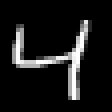

In [10]:
onefigure = X[:,3]
t1 = reshape(onefigure,28,28)
colorview(Gray,t1)

Appaiate alle matrici ci sono anche le etichette, l'etichetta di un immagine è poari al numero rappresentato dall immagine.  

In [12]:
labels = MNIST.labels()
labels[3]

4

Quando creeremo la rete questa, dato come input un immagine, restuirà la probabilità che sia un determinato numero, ovvero:  
m = x -> array[10] tale che array[i] = probabilità che x sia il nujmero i-1   
Quindi come veri valori convertiamo ogni etichetta in un array[10] dove array[i] = i se e solo se l'etichetta era il numero i-1, 0 altrimenti.  
Convertite tutte le etichette, mettiamole in una matrice, ognuna come una colonna.

In [15]:
Y = onehotbatch(labels, 0:9)

10×60000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  1  0  1  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  1     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  1  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  1  0  …  0  0  0  0  0  1  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  1  0  0  0  1
 0  0  0  0  1  0  0  0  0  0  0  0  0     0  0  1  0  1  0  0  0  0  0  0  0

Possiamo finalmente costruire la nostra rete:

In [16]:
m = Chain(
  Dense(28^2, 32, relu),
  Dense(32, 10),
  softmax);

All'inizio m non è allenata quindi ritornerà risultati molto poco sicuri:

In [17]:
@show probs = m(onefigure)
println("probabilità che l'immagine sia un 4 è: $(probs[5])")

probs = m(onefigure) = Float32[0.11287571, 0.101385094, 0.09992298, 0.106648214, 0.08723011, 0.1478958, 0.06867545, 0.107604906, 0.09495837, 0.072803386]
probabilità che l'immagine sia un 4 è: 0.08723011


Per migliorare il modello ci servono 2 funzioni:
* una funzione di accuracy ci dirà quanto dista una predizione dal vero valore del campione  
* una funzione loss calcola la qualità del modello al mutare dei pesi (un gradiente)  

Definiamole:

In [19]:
loss(x, y) = Flux.crossentropy(m(x), y)#da pacchetto flux
accuracy(x, y) = mean(argmax(m(x)) .== argmax(y));#media di quanto predizioni sian uguali a veri valori

Per aver più campioni ripetiamo il nostrto dataset, ci creiamo anche una funzione ausiliaria che ci stampi a schermo il risultato della loss a ogni passo:

In [21]:
datasetx = repeated((X, Y), 200)
C = collect(datasetx);
evalcb = () -> @show(loss(X, Y));

Per allenare il modello usiamo la funzione train del pacchetto Flux:

In [23]:
?Flux.train!

```
train!(loss, params, data, opt; cb)
```

For each datapoint `d` in `data`, compute the gradient of  `loss` with respect to `params` through backpropagation and call the optimizer `opt`.

If `d` is a tuple of arguments to `loss` call `loss(d...)`, else call `loss(d)`.

A callback is given with the keyword argument `cb`. For example, this will print "training" every 10 seconds (using [`Flux.throttle`](@ref)):

```
train!(loss, params, data, opt, cb = throttle(() -> println("training"), 10))
```

The callback can call [`Flux.stop`](@ref) to interrupt the training loop.

Multiple optimisers and callbacks can be passed to `opt` and `cb` as arrays.


In [30]:
ps = Flux.params(m)
opt = ADAM()
Flux.train!(loss#funzione loss
    , ps#parametri
    , datasetx#i nostri campioni su cui alleniamo
    , opt#ottimizzatore ADAM
    , cb = throttle(evalcb, 10)#callback
)

loss(X, Y) = 0.26093477f0
loss(X, Y) = 0.18951726f0
loss(X, Y) = 0.1484111f0
loss(X, Y) = 0.11963192f0


Abbiamo allenato il nostro modelloo, vediamo adesso se riesce effettivamente a dirci il numero scritto nell immagine che gli diamo:

In [34]:
tX = hcat(float.(reshape.(MNIST.images(:test), :))...);
test_image = m(tX[:,1])
numb = argmax(test_image)-1
println("il numero è un $numb")

il numero è un 7


Vediamo se ha ragione:

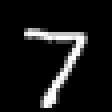

In [35]:
t1 = reshape(tX[:,1],28,28)
colorview(Gray, t1)

Riproviamo con l'immagine iniziale per la quale avevamo ricevuto risultato incerto:

il numero è un 4


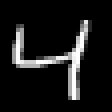

In [36]:
onefigure = X[:,3]
probs = m(onefigure)
mynum = argmax(probs)-1
t1 = reshape(onefigure,28,28)
println("il numero è un $mynum")
colorview(Gray, t1)

Il nostro modello sembra riuscire a dirci le immagini bene.